In [1]:
import numpy as np
from iaf.plot import plot_data
from iaf.fit.metrics import calc_sse
from iaf.notebook import init_style
init_style()

# Introduction to regression (curve fitting) -- Addendum

Here, we quickly discuss alternative solutions to the regression problem.

## Create some data to work with

In [2]:
a_real      = 3    # Real slope of the line.
b_real      = 10   # Real intercept of the line.
noise_level = 1.0  # Standard deviation of the noise around the line to mimick noisy measurements.

In [3]:
# Fix the seed of the random number generator
rng = np.random.RandomState(1)

In [4]:
# Our raw data
x = np.linspace(start=-10.0, stop=10.0, num=101)
y = a_real * x + b_real + noise_level * rng.randn(len(x))

We will use the `plot_data()` function quite a bit. Let's have a look at how we can use it.

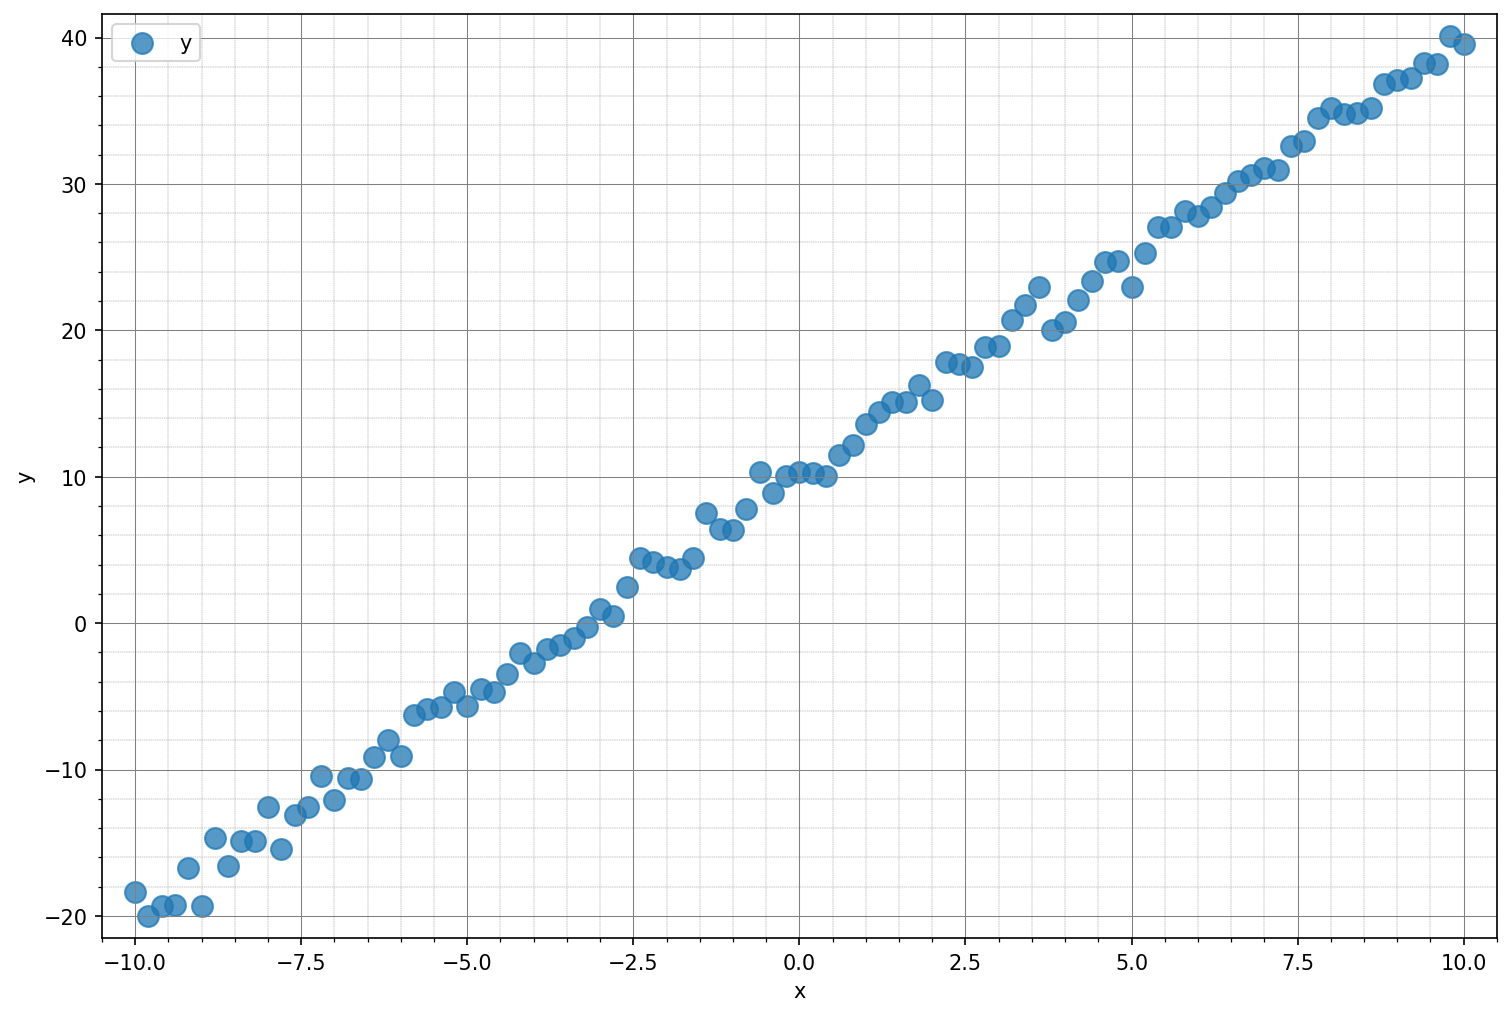

In [5]:
# Plot the data
_ = plot_data(x, y)

# Ordinary least squares

In **Ordinary Least Squares (OLS) Linear Regression**, we want to find the line (or hyperplane) that minimizes the differences between the predicted values $\hat{y}$ and the actual values $y$, that is, we find the line that minimizes the sum of squared errors (SSE).

In general, we can define our linear model as follows:

$$\hat{y} = \theta_0 + \theta_1x_1 + \theta_2x_2 +... + \theta_nx_n$$

Here,
* $\hat{y}$ is the predicted value,
* $n$ is number of features,
* $x_{i}$ is $i^{th}$ feature value,
* $\theta_{j}$ is $j^{th}$ model parameter (including the bias $j_{th}$.

It can be written in vector form as $\hat{y} = \mathbf{\theta} \cdot \mathbf{x}$, where:
* $\mathbf{\theta}$ is the model's parameter vector,
* $\mathbf{x}$ is instance's feature vector, with $x_{0}$ always equal to 1.

As we saw, we want to find the vector of parameters $\mathbf{\theta}$ that minimizes the **MSE** between $\hat{y}$ and $y$. Without deriving it, we present here the **normal equation** that calculates the vector of parameters $\mathbf{\theta}$ that minimized the MSE:

$$\hat{\theta} = \left(\mathbf{X}^{T}\mathbf{X}\right)^{-1}\mathbf{X}^{T}y$$

In Python:

In [6]:
X = np.concatenate((np.ones((len(x), 1)), x.reshape(len(x), 1)), axis=1) # Add x0 = 1 to each instance
y = y.reshape((len(y), 1))

In [7]:
theta_hat = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

In [8]:
theta_hat

array([[10.05555601],
       [ 3.01473939]])

Let's use the extimated parameters to calculate $\hat{y}$:

In [9]:
y_hat = X.dot(theta_hat)

In [10]:
a = theta_hat[1][0]
b = theta_hat[0][0]
sse = calc_sse(y, y_hat)

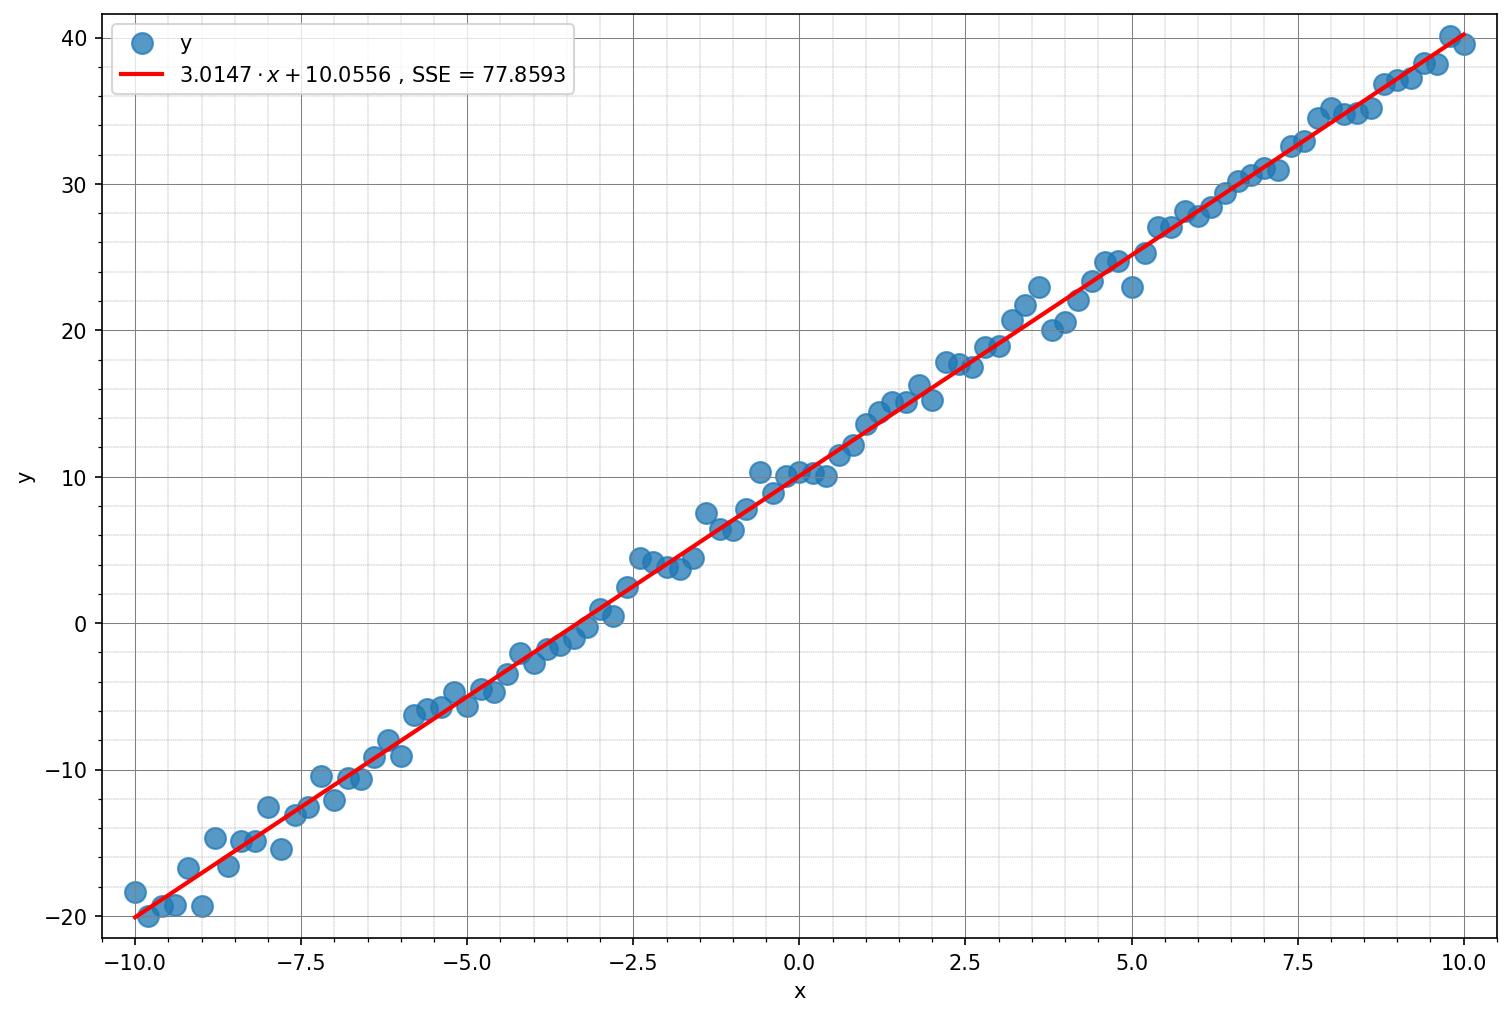

In [11]:
_ = plot_data(x, y.squeeze(), y_hat=y_hat, a=a, b=b, sse=sse)

## Singular-value decomposition

Calculating the inverse of $\left(\mathbf{X}^{T}\mathbf{X}\right)$ is not always numerically stable. A more robust approach uses the **pseudoinverse** of $\mathbf{X}$ (specifically, the Moore-Penrose inverse). This pseudo inverse is calculated using a standard matrix factorization technique called **Singular Value Decomposition (SVD)**. Without going into the details of the SVD, we can use `np.linalg.pinv(X)` (instead of `np.linalg.inv(X.T.dot(X))` to find $\mathbf{\hat{\theta}}$:

In [12]:
theta_hat = np.linalg.pinv(X).dot(y)

Let's use the extimated parameters to calculate $\hat{y}$:

In [13]:
y_hat = X.dot(theta_hat)

Let's plot the results:

In [14]:
a = theta_hat[1][0]
b = theta_hat[0][0]
sse = calc_sse(y, y_hat)

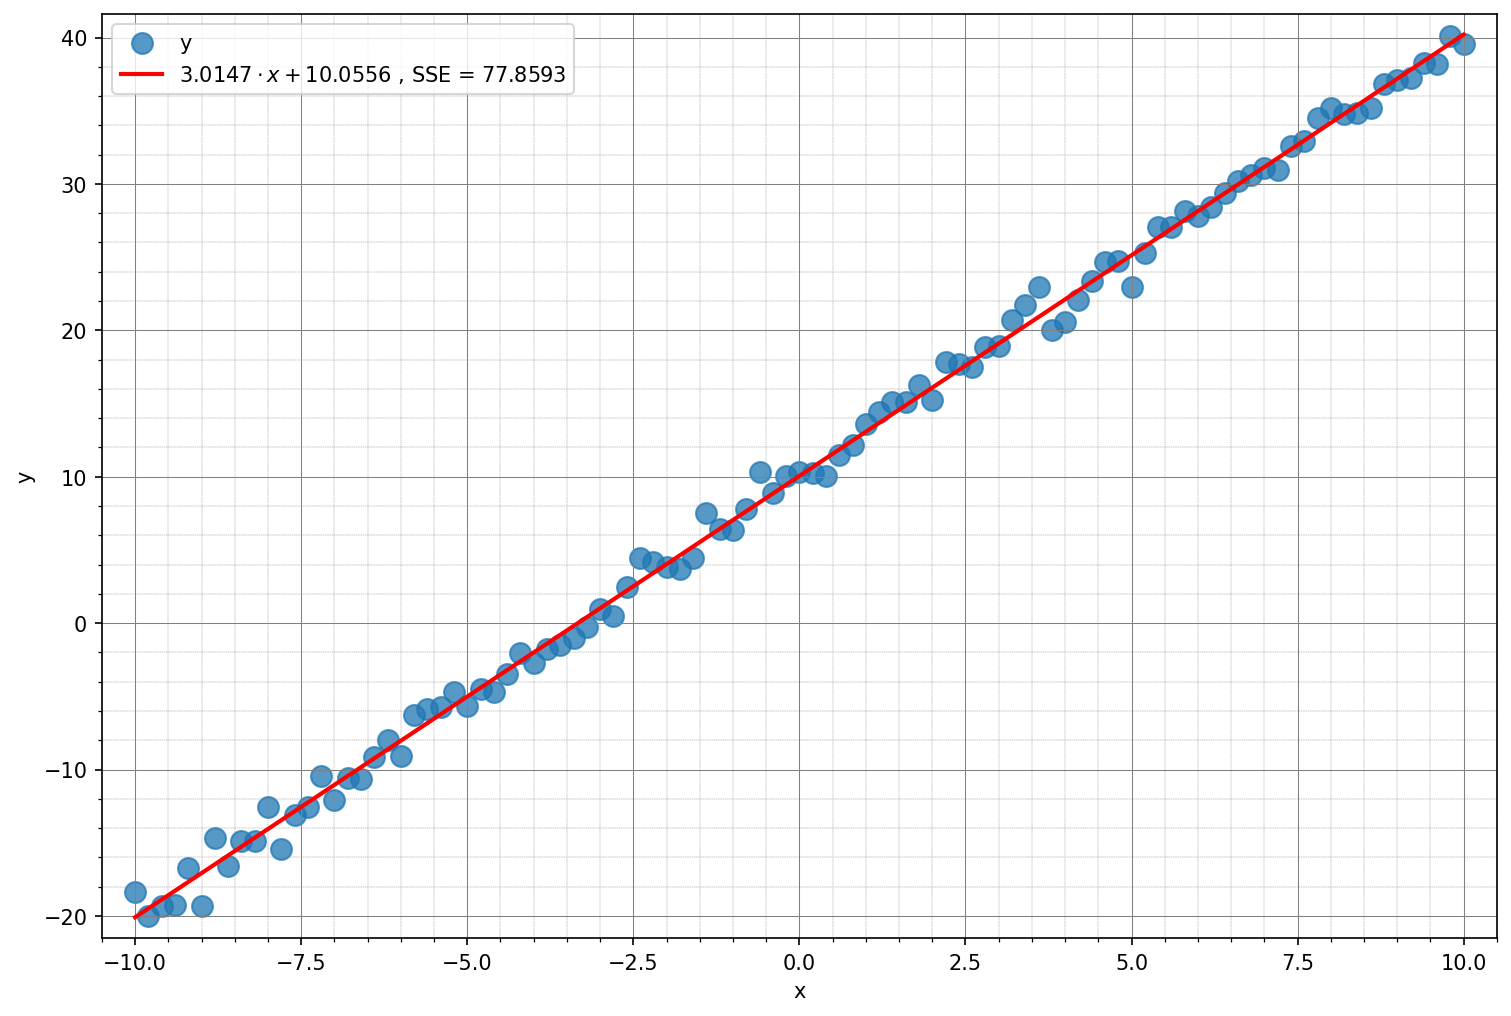

In [15]:
_ = plot_data(x, y.squeeze(), y_hat=y_hat.squeeze(), a=a, b=b, sse=sse)

# Gradient descent

## Batch gradient descent

In gradient descent, we need to compute the gradient of the cost function (that is, the MSE) with regard to each model parameter $\theta_{j}$. This means, that we need to calculate the partial derivative of the MSE for each parameter independently.

$$ \frac{\partial}{\partial \theta_{j}} \texttt{MSE}(\mathbf{\theta})=\frac{2}{m}\sum_{i=1}^{m}\left(\mathbf{\theta}^{T}x^{(i)}-y^{(i)}\right)x_{j}^{i}$$

All partial derivatives (gradient vector) can be calculated in one go as follows:

$$\nabla_{\mathbf{\theta}} \texttt{MSE}(\mathbf{\theta})= \begin{bmatrix}
           \frac{\partial}{\partial \theta_{0}} \texttt{MSE}(\mathbf{\theta}) \\
           \frac{\partial}{\partial \theta_{1}} \texttt{MSE}(\mathbf{\theta}) \\
           \vdots \\
           \frac{\partial}{\partial \theta_{n}} \texttt{MSE}(\mathbf{\theta}) \\
         \end{bmatrix} = \frac{2}{m}\mathbf{X}^{T}\left(\mathbf{X}\mathbf{\theta} - \mathbf{y}\right)$$

To update the parameter vector estimate, in each iteration we subtract (a fraction of) $\nabla_{\mathbf{\theta}} \texttt{MSE}(\mathbf{\theta})$ from $\mathbf{\theta}$. This is where the **learning rate** comes into play:

$$\mathbf{\theta}^{next}=\mathbf{\theta} - \eta \nabla_{\mathbf{\theta}} \texttt{MSE}(\mathbf{\theta})$$

## Quick Python implementation

In [16]:
eta = 0.001   # Learning rate
num_iterations = 10000
m = X.shape[0]

theta = np.random.randn(2, 1)   # Random initialization

for iteration in range(num_iterations):
    gradients = 2 / m * X.T.dot(X.dot(theta) - y)
    theta = theta - eta * gradients

In [17]:
theta

array([[10.05555598],
       [ 3.01473939]])

Let's use the extimated parameters to calculate $\hat{y}$:

In [18]:
y_hat = X.dot(theta)

Let's plot the results:

In [19]:
a = theta[1][0]
b = theta[0][0]
sse = calc_sse(y_hat, y)

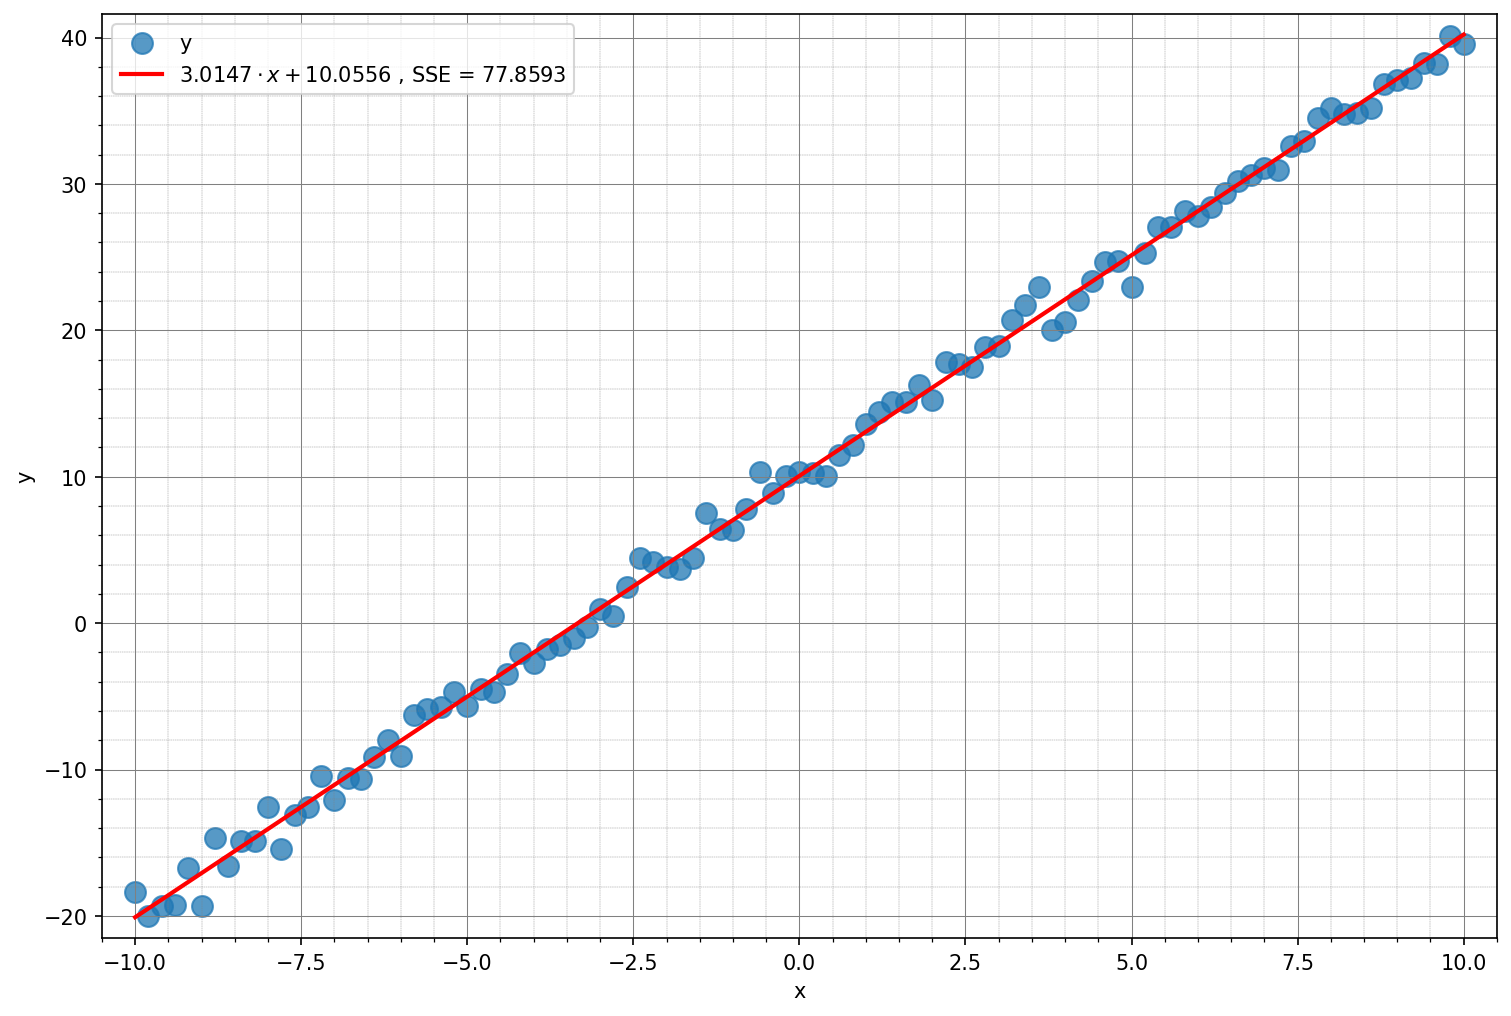

In [20]:
_ = plot_data(X[:, 1], y.squeeze(), y_hat=y_hat.squeeze(), a=a, b=b, sse=sse)

## Stochastic and mini-batch gradient descent 

**Batch gadient descent** uses the whole training set to compute the gradients at every step. For very large datasets, this can become very slow and memory-hungry.

**Stochastic gradient descent** picks a random instance in the training set and computes the gradient only on that single instance. This makes it very fast and capable of working on datasets of any size; on the other hand, due to its random nature, the cost function will bounce a lot, making convergence slower. Furthermore, even around the optimum, the weights will keep jumping, making the solution good, but not optimal.

**Mini-batch gradient descent** computes the gradients on small random sets of instances called *mini-batches*. The progress of the algorithm is less erratic than stochastic gradient descent (though it will also not necessarily find the optimum) but faster than Batch gradient descent. In practice, it can also take advantage of hardware acceleration when running on GPUs. 

We will not discuss the implementations of these two algorithms.